In [72]:
import json
import pandas as pd
from math import floor
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model # Keras is the new high level API for TensorFlow

In [74]:
print("Tensorflow Version: {}\nTensorflow Hub Version: {}".format(tf.__version__, hub.__version__))

Tensorflow Version: 2.1.0
Tensorflow Hub Version: 0.8.0


In [2]:
import os
os.chdir('/home/pablo/Desktop/test')

# To list all subdirectories in directory 'test':

In [267]:
x = "/home/pablo/Desktop/test/"
subdirs = [os.path.join(x, o) for o in os.listdir(x) if os.path.isdir(os.path.join(x,o))]
print(subdirs)

['/home/pablo/Desktop/test/n00006484', '/home/pablo/Desktop/test/n00005787']


In [268]:
for dirs in subdirs:
    print(dirs)

/home/pablo/Desktop/test/n00006484
/home/pablo/Desktop/test/n00005787


In [269]:
import numpy as np

for i in np.arange(0, len(subdirs)):
    print(subdirs[i])

/home/pablo/Desktop/test/n00006484
/home/pablo/Desktop/test/n00005787


In [270]:
import numpy as np
filenamez=[]

for i in np.arange(0, len(subdirs)):
    names=os.listdir(subdirs[i])
    filenamez.append(names)
    print(subdirs[i])

/home/pablo/Desktop/test/n00006484
/home/pablo/Desktop/test/n00005787


In [7]:
len(names)

3171

# Get all the full paths (not relative paths) for each item in the dataset

In [271]:
import os
new_dirs=[]
files = []
for dirs in subdirs:
    # r=root, d=directories, f = files
    for r, d, f in os.walk(dirs):
        for file in f:
            files.append(os.path.join(r, file))
            new_dirs.append(os.path.split(dirs)[1])

In [9]:
len(new_dirs)

5984

In [10]:
len(files)

5984

# Concat the lists into a dataframe for processing (next step)

In [272]:
df = pd.DataFrame(list(zip(files, new_dirs)), columns=['metadata_file','target'])

### Because all files except for the meta files have extensions Python recognizes, I'm dropping all extensions and keeping only unique values because these will be the JSON files (each file with an extension has an associated meta file). I'm doing this in a full dataframe so the class labels retain the same indices as the data:

In [273]:
df.metadata_file[1]

'/home/pablo/Desktop/test/n00006484/rp-841i5IwFoxM.jpg'

Take the first index before the split:

In [ ]:
# To list all files and their full paths (without extensions):
#xyz=[]
xyz=pd.Series()

for i in np.arange(len(df)):
    df['metadata_file'][i] = df['metadata_file'][i].split(".")[0]

In [275]:
df.metadata_file[1]

'/home/pablo/Desktop/test/n00006484/rp-841i5IwFoxM'

In [276]:
len(df)

5984

In [277]:
len(df.drop_duplicates())

3003

### Drop duplicates like mentioned above:

In [278]:
df = df.drop_duplicates().copy()

In [20]:
len(df)

3003

In [21]:
df.head()

,metadata_file,target
0,/home/pablo/Desktop/test/n00006484/aPkDH6Plnh1XHM,n00006484
1,/home/pablo/Desktop/test/n00006484/rp-841i5IwFoxM,n00006484
2,/home/pablo/Desktop/test/n00006484/Eud7D3RdzbTRAM,n00006484
3,/home/pablo/Desktop/test/n00006484/zi6RzWIEvqGCRM,n00006484
4,/home/pablo/Desktop/test/n00006484/j705FxfCA2CjCM,n00006484


### Converting Pandas back to lists for faster processing with JSON reading:

In [279]:
filelist = list(df.metadata_file)
classlist = list(df.target)

In [280]:
print("Shape of the metadata filename list: {}\nShape of metadata target list: {}".format(np.array(filelist).shape, np.array(classlist).shape))

Shape of the metadata filename list: (3003,)
Shape of metadata target list: (3003,)


In [353]:
descriptions=[]
ids=[]
targets=[]
pathz=[]
new_dirs=[]
titles=[]

for file in filelist:
    with open(file) as f:
        json_data = json.load(f)
        descriptions.append(json_data['description'])
        ids.append(json_data['id'])
        titles.append(json_data['title'])

# Remove all non-ascii characters (including foreign languages (there was a lot of japanese)):

In [354]:
new_titles = []
new_descriptions = []

# encode as ascii, decode to convert back to characters from bytes. Also, do regex cleanup on special characters not indicative of meaning
for title in titles:
    new_titles.append(re.sub(r"[^a-zA-Z?.!,¿#@]+", " ",title.encode('ascii',errors='ignore').decode('UTF-8')))
    
for description in descriptions:
    new_descriptions.append(re.sub(r"[^a-zA-Z?.!,¿#@]+", " ",description.encode('ascii',errors='ignore').decode('UTF-8')))

In [355]:
for i in range(len(new_titles)):
    new_titles[i] = new_titles[i].lower()

for i in range(len(new_descriptions)):
    new_descriptions[i] = new_descriptions[i].lower()

In [356]:
targets = pd.Series(df['target']).reset_index(drop=True)

In [321]:
targets.tail()

2998    n00005787
2999    n00005787
3000    n00005787
3001    n00005787
3002    n00005787
Name: target, dtype: object

In [322]:
targets.tail()

2998    n00005787
2999    n00005787
3000    n00005787
3001    n00005787
3002    n00005787
Name: target, dtype: object

In [357]:
# put words into a dictionary for downstream use
import collections
def build_dataset(words):
    count = collections.Counter(words).most_common() #.most_common(100) to use the 100 most common words; .most_common() means zero is the most common
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return dictionary, reverse_dictionary

In [496]:
titles_train = new_titles[:floor(len(new_titles)*.75)]
titles_test = new_titles[floor(len(new_titles)*.75):]

descriptions_train = new_descriptions[:floor(len(new_descriptions)*.75)]
descriptions_test = new_descriptions[floor(len(new_descriptions)*.75):]

targets_train = targets[:floor(len(targets)*.75)]
targets_test = targets[floor(len(targets)*.75):]

In [359]:
print("Title train length: {}\nDescription train length: {}\nTarget train length: {}\n\nTitle test length: {}\nDescription test length: {}\nTarget test length: {}".format(len(titles_train), len(descriptions_train), len(targets_train), len(titles_test), len(descriptions_test), len(targets_test)))

Title train length: 2252
Description train length: 2252
Target train length: 2252

Title test length: 751
Description test length: 751
Target test length: 751


# Setting up Title Encoding (dictionarize for ALL titles (not just train or test))

In [360]:
title_word_list=[]

for i in np.arange(len(new_titles)):
    title_word_list.append(new_titles[i].split())

In [361]:
title_flat_list = []

for sublist in title_word_list:
    for item in sublist:
        title_flat_list.append(item)

In [362]:
title_word_list = title_flat_list.copy()

In [363]:
title_words_unique = list(set(title_word_list))

In [364]:
print("Unique train titles word count: {}\nUnique validation titles word count: {}".format(len(title_words_unique), len(title_words_unique)))

Unique train titles word count: 4601
Unique validation titles word count: 4601


In [365]:
from collections import Counter

title_word_to_id = Counter()

for word in title_word_list:
    title_word_to_id[word] += 1

In [366]:
# For unique dictionary values of key words
title_word_to_id = {k:(i + 3) for i,(k,v) in enumerate(title_word_to_id.items())}

### Checking to make sure the 10 most common words only appear once:

In [367]:
Counter(title_word_to_id.values()).most_common(10)

[(3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1)]

In [368]:
from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

take(10, title_word_to_id.items())

[('the', 3),
 ('cell', 4),
 ('cycle.', 5),
 ('life', 6),
 ('of', 7),
 ('just', 8),
 ('like', 9),
 ('an', 10),
 ('organism', 11),
 ('...', 12)]

In [369]:
title_word_to_id["<PAD>"] = 0 # there is no value this replaces; it just adds a pad
title_word_to_id["<START>"] = 1 # BERT doesn't use START tokens so using spaces instead; spaces will be trimmed out
title_word_to_id["<UNK>"] = 2 # UNK tokens are good. BERT converts them to ## so it knows it's unknown
title_word_to_id["<UNUSED>"] = 3

In [370]:
title_id_to_word = {value:key for key, value in title_word_to_id.items()}

### End of title encoding dictionary

# Setting up Descriptions Encoding (dictionarize for ALL descriptions (not just train or test))

In [371]:
description_word_list=[]

for i in np.arange(len(new_descriptions)):
    description_word_list.append(new_descriptions[i].split())

In [372]:
description_flat_list = []

for sublist in description_word_list:
    for item in sublist:
        description_flat_list.append(item)

In [373]:
description_word_list = description_flat_list.copy()

In [374]:
description_words_unique = list(set(description_word_list))

In [375]:
print("Unique train titles word count: {}\nUnique validation titles word count: {}".format(len(description_words_unique), len(description_words_unique)))

Unique train titles word count: 8356
Unique validation titles word count: 8356


In [376]:
from collections import Counter

description_word_to_id = Counter()

for word in description_word_list:
    description_word_to_id[word] += 1

In [377]:
# For unique dictionary values of key words
description_word_to_id = {k:(i + 3) for i,(k,v) in enumerate(description_word_to_id.items())}

### Checking to make sure the 10 most common words only appear once:

In [378]:
Counter(description_word_to_id.values()).most_common(10)

[(3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1)]

In [379]:
from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

take(10, description_word_to_id.items())

[('life', 3),
 ('science', 4),
 ('chapter', 5),
 ('the', 6),
 ('cell', 7),
 ('in', 8),
 ('action.', 9),
 ('diffusion', 10),
 ('movement', 11),
 ('from', 12)]

In [381]:
description_word_to_id["<PAD>"] = 0 # there is no value this replaces; it just adds a pad
description_word_to_id["<START>"] = 1 # BERT doesn't use START tokens so using spaces instead; spaces will be trimmed out
description_word_to_id["<UNK>"] = 2 # UNK tokens are good. BERT converts them to ## so it knows it's unknown
description_word_to_id["<UNUSED>"] = 3

In [382]:
description_id_to_word = {value:key for key, value in description_word_to_id.items()}

In [ ]:
# print(' '.join(description_id_to_word[id] for id in descriptions_test[0])) # This fails because I have words, but this is designed for encoded integer values

### End of descriptions encoding dictionary

# BERT Model setup:

In [75]:
from tensorflow.keras.models import Model # Keras is the new high level API for TensorFlow

#max_seq_length = 128  # Your choice here.
max_seq_length = 512  # Your choice here.
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length), dtype=tf.int32,
                                    name="segment_ids")
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",
                            trainable=True)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

In [76]:
import bert
import math

# Set up tokenizer to generate Tensorflow dataset
FullTokenizer = bert.bert_tokenization.FullTokenizer
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file, do_lower_case)
print("Vocab size:", len(tokenizer.vocab))

Vocab size: 30522


# BERT Tokenizer setup for the dataset:

### Example with BERT tokenizer:

In [307]:
tokens = tokenizer.tokenize("Nickelodeon Cel: Production Art | eBay")
print(tokens)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

['nickelodeon', 'ce', '##l', ':', 'production', 'art', '|', 'e', '##bay']
[20814, 8292, 2140, 1024, 2537, 2396, 1064, 1041, 15907]


### Add the CLS (classification start) and SEP  (separate sentences) tokens required for BERT per the BERT paper:

In [469]:
train_titles_tokens = list(map(lambda titles_train: ['[CLS]'] + tokenizer.tokenize(titles_train)[:510] + ['[SEP]'], titles_train))
test_titles_tokens = list(map(lambda titles_test: ['[CLS]'] + tokenizer.tokenize(titles_test)[:510] + ['[SEP]'], titles_test))

### The first method below (lambda) isn't working for the descriptions so need to run the latter functions in stead.

In [ ]:
# train_descriptions_tokens = list(map(lambda descriptions_train: ['[CLS]'] + tokenizer.tokenize(descriptions_train)[:510] + ['[SEP]'], descriptions_train))
# test_descriptions_tokens = list(map(lambda descriptions_test: ['[CLS]'] + tokenizer.tokenize(descriptions_test)[:510] + ['[SEP]'], descriptions_test))

In [497]:
description_train_tokens = []
for desc_train in descriptions_train:
    desc_train = ['[CLS]'] + tokenizer.tokenize(desc_train)[:510] + ['[SEP]']
    description_train_tokens.append(desc_train)

In [498]:
description_test_tokens = []
for desc_test in descriptions_test:
    desc_test = ['[CLS]'] + tokenizer.tokenize(desc_test)[:510] + ['[SEP]']
    description_test_tokens.append(desc_test)

# Generate the masks, segment IDs, and tokens for the BERT machine:

In [467]:
# See BERT paper: https://arxiv.org/pdf/1810.04805.pdf
# And BERT implementation convert_single_example() at https://github.com/google-research/bert/blob/master/run_classifier.py

###############################
# RDS  modifications to these #
# functions to simply return  #
# numpy arrays                #
###############################

def get_ids(tokens, tokenizer, max_seq_length):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return np.array(input_ids)

def get_masks(tokens, max_seq_length):
    """Mask for padding"""
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    return np.array([1]*len(tokens) + [0] * (max_seq_length - len(tokens)))


def get_segments(tokens, max_seq_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    if len(tokens)>max_seq_length:
        raise IndexError("Token length more than max seq length!")
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return np.array(segments + [0] * (max_seq_length - len(tokens)))

In [507]:
max_seq_length = 512

train_title_tokens_ids = []
test_title_tokens_ids = []

train_description_tokens_ids = []
test_description_tokens_ids = []

for i in np.arange(0, len(train_titles_tokens)):
    this_train_title_token_id = get_ids(train_titles_tokens[i], tokenizer, max_seq_length=max_seq_length)
    train_title_tokens_ids.append(this_train_title_token_id)

for i in np.arange(0, len(test_titles_tokens)):
    this_test_title_token_id = get_ids(test_titles_tokens[i], tokenizer, max_seq_length=max_seq_length)
    test_title_tokens_ids.append(this_test_title_token_id)

for i in np.arange(0, len(description_train_tokens)):
    this_train_description_token_id = get_ids(description_train_tokens[i], tokenizer, max_seq_length=max_seq_length)
    train_description_tokens_ids.append(this_train_description_token_id)

for i in np.arange(0, len(description_test_tokens)):
    this_test_description_token_id = get_ids(description_test_tokens[i], tokenizer, max_seq_length=max_seq_length)
    test_description_tokens_ids.append(this_test_description_token_id)

In [481]:
pd.DataFrame(tokens_ids).shape

(751, 512)

In [482]:
print('Input token IDs dimensions: {}\n'.format(pd.DataFrame(tokens_ids).shape))

Input token IDs dimensions: (751, 512)



In [483]:
print("Input token IDs (NOT truncated):\n\n", tokens_ids[3][0:250])

Input token IDs (NOT truncated):

 [  101  5532 16012  4168  1037 15764  5009  2000  2049  4176  1998  4264
   102     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0    

# 4) Create text masks for BERT

In [527]:
max_seq_length = 512
    
train_title_tokens_masks = []
test_title_tokens_masks = []

train_description_tokens_masks = []
test_description_tokens_masks = []

for i in np.arange(0, len(train_titles_tokens)):
    this_train_title_token_mask = get_masks(train_titles_tokens[i], max_seq_length=max_seq_length)
    train_title_tokens_masks.append(this_train_title_token_mask)

for i in np.arange(0, len(test_titles_tokens)):
    this_test_title_token_mask = get_masks(test_titles_tokens[i], max_seq_length=max_seq_length)
    test_title_tokens_masks.append(this_test_title_token_mask)

for i in np.arange(0, len(description_train_tokens)):
    this_train_description_token_mask = get_masks(description_train_tokens[i], max_seq_length=max_seq_length)
    train_description_tokens_masks.append(this_train_description_token_mask)

for i in np.arange(0, len(description_test_tokens)):
    this_test_description_token_mask = get_masks(description_test_tokens[i], max_seq_length=max_seq_length)
    test_description_tokens_masks.append(this_test_description_token_mask)

In [529]:
print("Training input masks for first title:\n\n", train_title_tokens_masks[0])

Training input masks for title:

 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [537]:
print("Training input masks for first description:\n\n", train_description_tokens_masks[0])

Training input masks for description:

 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

# 5) Create text segments for BERT

In [538]:
max_seq_length = 512

train_title_tokens_segs = []
test_title_tokens_segs = []

train_description_tokens_segs = []
test_description_tokens_segs = []

input_seg = []
for i in np.arange(0, len(train_titles_tokens)):
    this_train_title_token_seg = get_segments(train_titles_tokens[i], max_seq_length=max_seq_length)
    train_title_tokens_segs.append(this_train_title_token_seg)

for i in np.arange(0, len(test_titles_tokens)):
    this_test_title_token_seg = get_segments(test_titles_tokens[i], max_seq_length=max_seq_length)
    test_title_tokens_segs.append(this_test_title_token_seg)

for i in np.arange(0, len(description_train_tokens)):
    this_train_description_token_seg = get_segments(description_train_tokens[i], max_seq_length=max_seq_length)
    train_description_tokens_segs.append(this_train_description_token_seg)

for i in np.arange(0, len(description_test_tokens)):
    this_test_description_token_seg = get_segments(description_test_tokens[i], max_seq_length=max_seq_length)
    test_description_tokens_segs.append(this_test_description_token_seg)

In [539]:
print("Training input segments for first title:\n\n", train_title_tokens_segs[0])

Training input segments for first movie review:

 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [540]:
print("Training input segments for first description:\n\n", train_description_tokens_segs[0])

Training input segments for first description:

 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

# End of BERT Data Pre-Processing

### BELOW IS A WIP:

In [303]:
max_seq_length = 500  # Your choice here.
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length), dtype=tf.int32,
                                    name="segment_ids")
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
classifier1 = tf.keras.layers.Dense(100,activation='sigmoid')(pooled_output)
classifier2 = tf.keras.layers.Dense(1,activation='sigmoid')(classifier1)

In [304]:
model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=[classifier2])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 500)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 500)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 500)]        0                                            
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      multiple             109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

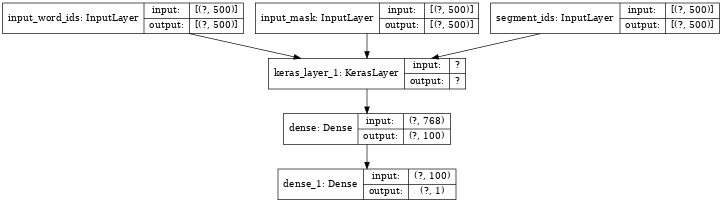

In [305]:
import graphviz
import pydot

model.summary() # second pass with 500 sequence length
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

# The above will need to be done in a tensorflow 2.1.0 environment. After everything is done and it is time to run the BERT, there will need to be another Python script that runs the model in M2